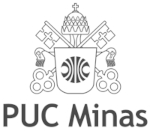

## Programa de Pós Graduação em Informática

### Disciplina: Natural Language Processing (NLP)

### Aluno: Felipe A. L. Reis

---
## Descrição do Método (Word2Vec)

Para solução do problema utilizando Word2Vec, foi criado um algoritmo não supervisionado que calcula os valores esperados para a similaridade entre expressões. O modelo utiliza o Word2Vec para analisar a correlação entre as palavras e estabelecer uma métrica de similaridade.

Os valores definidos pelo algoritmo foram feitos com base na criação manual do algoritmo, a partir do entendimento dos dados, obtidos na avaliação da base de dados, no experimento usando TF-IDF e com auxílio dos scores existentes no conjunto de treinamento.

O algoritmo tenta associar palavras individualmente, estabelendo um *score* para a expressão de forma global.
Para isso, o algoritmo encontra as palavras similares usando o Word2Vec. 
O valor de similaridade entre as palavras é usada para cálculo do valor final.

Devido a características da base de dados, foran observadas algumas correlações entre expressões, de modo que foi possível estabelecer um algoritmo adequado.
O algoritmo executa processos diferente, de acordo com a quantidade de palavras na **frase-âncora** e **frase-alvo**, conforme detalhado abaixo (seguindo ordem de precedência):

* **1 palavra na âncora e também no alvo**;
* **Quantidade iguais de palavras na âncora e no alvo**;
* **Quantidade diferente de palavras na âncora e no alvo**.

No projeto, foram utilizados diferentes modelos Word2Vec pré-treinados, detalhados abaixo:

* *glove-wiki-gigaword-100*, por [RaRe-Technologies](https://github.com/RaRe-Technologies/gensim-data)
* *glove-wiki-gigaword-300*, por [RaRe-Technologies](https://github.com/RaRe-Technologies/gensim-data)
* *word2vec-google-news-300*, por [RaRe-Technologies](https://github.com/RaRe-Technologies/gensim-data)
* *w2vec_patent_domain*, por [Mustafa Sofean](https://www.kaggle.com/darshmso) 

Os três primeiros modelos foram disponibilizados pela biblioteca [Gensim](https://radimrehurek.com/gensim/index.html), em contextos genéricos, como notícias e informações do Wikipedia.

O último modelo foi publicado em 2018 na comunidade Kaggle e corresponde ao treinamento do Word2Vec no contexto de patentes (apesar de não diretamente relacionado às patentes da competição). O link para download do modelo é:   https://www.kaggle.com/datasets/darshmso/w2vec-patent-domain.

---
## Importação de Bibliotecas

In [13]:
%load_ext autoreload
%autoreload 2
from nlputil import load_data, split_data, get_examples, do_lemma_stemmer, calcula_correlacao

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import datetime
import os, shutil
from scipy import stats

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer, LancasterStemmer
from nltk.tag.perceptron import PerceptronTagger

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')
nltk.download('omw-1.4')

stops = set(stopwords.words('english'))

import gensim
import gensim.downloader as api
from gensim.models import Word2Vec, Doc2Vec, FastText

[nltk_data] Downloading package punkt to /home/falreis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/falreis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/falreis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/falreis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /home/falreis/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/falreis/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


---
## Aplicação de Pré Processamento Textual

In [16]:
test = load_data('dataset/test.csv')
data = load_data('dataset/train.csv')
codes = load_data('dicionario_dados/titles.csv')

codes = codes.drop(['subclass','group', 'main_group', 'section', 'class'], axis=1)

data['match'] = 0
data

id        anchor                  target context  score  \
0      37d61fd2272659b1     abatement  abatement of pollution     A47   0.50   
1      7b9652b17b68b7a4     abatement          act of abating     A47   0.75   
2      36d72442aefd8232     abatement         active catalyst     A47   0.25   
3      5296b0c19e1ce60e     abatement     eliminating process     A47   0.50   
4      54c1e3b9184cb5b6     abatement           forest region     A47   0.00   
...                 ...           ...                     ...     ...    ...   
36468  8e1386cbefd7f245  wood article          wooden article     B44   1.00   
36469  42d9e032d1cd3242  wood article              wooden box     B44   0.50   
36470  208654ccb9e14fa3  wood article           wooden handle     B44   0.50   
36471  756ec035e694722b  wood article         wooden material     B44   0.75   
36472  8d135da0b55b8c88  wood article        wooden substrate     B44   0.50   

       match  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
36468      0  
36469      0  
36470      0  
36471      0  
36472      0  

[36473 rows x 6 columns]

---
## Solução usando Word2Vec e Doc2Vec

No projeto, foram utilizados diferentes modelos Word2Vec pré-treinados, detalhados abaixo:

* *glove-wiki-gigaword-100*, por [RaRe-Technologies](https://github.com/RaRe-Technologies/gensim-data)
* *glove-wiki-gigaword-300*, por [RaRe-Technologies](https://github.com/RaRe-Technologies/gensim-data)
* *word2vec-google-news-300*, por [RaRe-Technologies](https://github.com/RaRe-Technologies/gensim-data)
* *w2vec_patent_domain*, por [Mustafa Sofean](https://www.kaggle.com/darshmso) 

Os três primeiros modelos foram disponibilizados pela biblioteca [Gensim](https://radimrehurek.com/gensim/index.html), em contextos genéricos, como notícias e informações do Wikipedia.

O último modelo foi publicado em 2018 na comunidade Kaggle e corresponde ao treinamento do Word2Vec no contexto de patentes (apesar de não diretamente relacionado às patentes da competição). O link para download do modelo é:   https://www.kaggle.com/datasets/darshmso/w2vec-patent-domain.

Os resultados obtidos com os modelos *word2vec-google-news-300* e *w2vec_patent_domain* foram semelhantes.
Em ambos os modelos não foram utilizados todas as expressões existentes - foram utilizadas entre 100.000 e 1.000.000 de expressões, ordenadas por frequência, com diferenças pouco significativas nos resultados obtidos.

In [34]:
#w2vec_model = gensim.models.KeyedVectors.load_word2vec_format(model, binary=True, limit=100000)
#w2vec_model = api.load('glove-wiki-gigaword-300')

model_txt = 'models/W2Vec_Patent_Domain.txt'
w2vec_model = gensim.models.KeyedVectors.load_word2vec_format(model_txt, binary=False, limit=500000)

print(len(w2vec_model))

500000


Verifica a similaridade com uma palavra de exemplo.

In [35]:
w2vec_model.most_similar('article', topn=200)

[('molded', 0.7683151960372925),
 ('product', 0.701513409614563),
 ('absorbent', 0.6903672814369202),
 ('item', 0.665777325630188),
 ('articles', 0.663340151309967),
 ('object', 0.6549117565155029),
 ('formed', 0.64738529920578),
 ('surface', 0.642366349697113),
 ('sheet', 0.642005205154419),
 ('shaped', 0.6341705322265625),
 ('coated', 0.6247141361236572),
 ('cured', 0.6111357808113098),
 ('label', 0.6063483357429504),
 ('finished', 0.6043567657470703),
 ('member', 0.5992923378944397),
 ('absorptive', 0.5879621505737305),
 ('elongated', 0.5826326012611389),
 ('portion', 0.5809356570243835),
 ('knitted', 0.5802246928215027),
 ('area', 0.579827070236206),
 ('device', 0.5784189105033875),
 ('treated', 0.5773316621780396),
 ('manufactured', 0.5748008489608765),
 ('moulded', 0.5747495293617249),
 ('region', 0.5741075873374939),
 ('web', 0.5697225332260132),
 ('predetermined', 0.5686858892440796),
 ('three-dimensional', 0.5675063133239746),
 ('packaged', 0.5617095828056335),
 ('tool', 0.559

In [36]:
data[data.anchor == 'abatement'] #.head()

id     anchor                                       target  \
0   37d61fd2272659b1  abatement                       abatement of pollution   
1   7b9652b17b68b7a4  abatement                               act of abating   
2   36d72442aefd8232  abatement                              active catalyst   
3   5296b0c19e1ce60e  abatement                          eliminating process   
4   54c1e3b9184cb5b6  abatement                                forest region   
5   067203128142739c  abatement                             greenhouse gases   
6   061d17f04be2d1cf  abatement                               increased rate   
7   e1f44e48399a2027  abatement                            measurement level   
8   0a425937a3e86d10  abatement                            minimising sounds   
9   ef2d4c2e6bbb208d  abatement                        mixing core materials   
10  4c3f2750e7540ab7  abatement             multi pollution abatement device   
11  84261a11e5d1b68b  abatement                              noise reduction   
12  bfd7270f57530991  abatement                          pollution abatement   
13  b3832eac81b73dfd  abatement              pollution abatement incinerator   
14  9001756895ec8ca1  abatement                        pollution certificate   
15  cc96541d4987b399  abatement                               rent abatement   
16  deb9204cd9783e8b  abatement                             sorbent material   
17  45db77f26e5ac39f  abatement  source items pollution abatement technology   
18  1222e36d9a94c2a4  abatement                              stone abutments   
19  a8c9e9f37d4d836a  abatement                                tax abatement   
20  c450cc69fa315db9  abatement                                 water bodies   
21  09913d3964d4c881  abatement                           emission abatement   
22  87af8ea095cc18d4  abatement                                   prevention   
23  d7bb1ea2b761fef2  abatement                                  prophylaxis   
24  f6dfaebab0d209b7  abatement                          pollution abatement   
25  ee25d53aac9ecaf0  abatement                          abatement apparatus   
26  4fd7d0a3b8887846  abatement                                    treatment   
27  506f8d0a6feae789  abatement                          abatement apparatus   
28  473137168ebf7484  abatement                                      abating   
29  56acc49e0f5da095  abatement                                  central hub   
30  bc5af15a01442792  abatement                                control panel   
31  c652ac20bb14b2b0  abatement                                   deficiency   
32  f0b0f0898ec291eb  abatement                             diminished chord   
33  4bb652c1091f3d1d  abatement                             diminished image   
34  142436708875e523  abatement                                  diminishing   
35  b539d0f45bff2213  abatement                                  eliminating   
36  fde22bfb2f89383c  abatement                        eliminating emissions   
37  e490558573ed44ff  abatement                       eliminating pollutants   
38  62dbb14376eb40ac  abatement                                   increasing   
39  13b13c212a1756f5  abatement                             increasing order   
40  8524aecd17299b63  abatement                                   mitigation   
41  f1c655d247630730  abatement                            pollution control   
42  6917b6123c373233  abatement                              processing unit   
43  7ab0bc7f2b94c401  abatement                      removing air pollutants   
44  4d9fb5ff45c8ab1d  abatement                                    subsiding   
45  1d4a73e6a5e56a01  abatement                           treating emissions   
46  98a851a58d837fb0  abatement                              noise abatement   
47  09db0a872aa1d88c  abatement                              noise abatement   
48  6bdd1d05ffa3401e  abatement                           emission abatement   

   context  score

### Algoritmo Não Supervisionado

O algoritmo executa processos diferente, de acordo com a quantidade de palavras na **frase-âncora** e **frase-alvo**, conforme detalhado abaixo (seguindo ordem de precedência):

* **1 palavra na âncora e também no alvo**: 
* * No cenário, o valor de similaridade recuperado pelo Word2Vec é definido como o valor de similaridade da expressão;
* **Quantidade iguais de palavras na âncora e no alvo**: 
* * No cenário, a similaridade de cada uma das palavras é somada, sendo que a palavra *n* na expressão tem seu valor de similaridade dividido por *n*. 
* * A soma das similaridades tem como objetivo indicar que expressões com mais palavras e que sejam muito próximas, realmente tem probabilidade mais alta de terem um mesmo significado.
* * Em caso de expressões idênticas, a similidade da palavra é definida como 0,5;
* * O decréscimo de similaridade foi adotado ao se observar que, em geral, a primeira palavra corresponde a um adjetivo que caracteriza o objeto, enquanto a segunda palavra tem conotação mais genérica. Com isso, a primeira expressão tem um peso maior, pois caracteriza mais o objeto. *Obs.: foram analisados diferentes métodos para combinar expressões*.
* **Quantidade diferente de palavras na âncora e no alvo**:
* * No cenário, a similaridade entre palavras é dividida pelo número de termos, produzindo a similaridade média.

In [37]:
def calc_similarity(data, topn=50):
    stop_words = set(stopwords.words('english'))
    wnl = WordNetLemmatizer()

    #data = data[data.anchor == 'wood article']
    #data = data[data.id == '756ec035e694722b']
    print('start:', datetime.datetime.now())

    index = 0
    for d in data.iterrows():
        index += 1
        score = 0.

        anchor = d[1]['anchor']
        target = d[1]['target']

        anchors = anchor.split()
        targets = target.split()

        len_anchors = len(anchors)
        len_targets = len(targets)
        max_len = max(len_anchors, len_targets)

        #lematiza palavras
        for i in range(len(anchors)):
            anchors[i] = wnl.lemmatize(anchors[i])

        for i in range(len_targets):
            targets[i] = wnl.lemmatize(targets[i])

        #verifica se a expressão é igual
        if(''.join(anchors) == ''.join(targets)):
            score = 1.
        else:
            #compara palavras individuais
            if(len_anchors == 1 and len_targets == 1):
                try:
                    similars = w2vec_model.most_similar(anchors[0], topn=topn)

                    for sim in similars:
                        if(targets[0].lower() == sim[0].lower()):
                            score += sim[1]
                            break
                except:
                    pass

            elif(len_anchors == len_targets):
                idx = 0
                for anch, targ in zip(anchors, targets):
                    idx += 1
                    if targ not in stop_words and anch not in stop_words:
                        try:
                            similars = w2vec_model.most_similar(anch, topn=topn)
                            if(anch.lower() == targ.lower()):
                                score += 0.5 / idx
                            else:
                                #busca similaridades baseados no anchor
                                for sim in similars:
                                    if(targ.lower() == sim[0].lower()):
                                        score += sim[1] / idx
                                        break
                        except:
                            pass    

            else:                   
                #compara as palavras, a fim de encontrar similaridade entre as expressões
                for anch in anchors:
                    try:
                        similars = w2vec_model.most_similar(anch, topn=topn)

                        for targ in targets:
                            if targ not in stop_words and anch not in stop_words:
                                if(anch.lower() == targ.lower()):
                                    if(len_anchors == 1 or len_targets == 1):
                                        score += 0.5
                                    else:
                                        score += (1. / (len_anchors + len_targets))
                                else:
                                    #busca similaridades baseados no anchor
                                    found_sim = False
                                    for sim in similars:
                                        for s in sim[0].split('_'):
                                            if(targ.lower() == s.lower()):
                                                score += sim[1] / max_len
                                                found_sim = True
                                                break

                                        if(found_sim):
                                            break
                    except:
                        pass

        score = (1. if score > 1. else score)
        #score = round(score * 4) / 4

        data.loc[d[0],'match'] = score

        print(index, '/', len(data), '\r', end='')

    print()
    print('end:', datetime.datetime.now())
    
    return data

### Similaridade no Treinamento

Calcula a similaridade no conjunto de treinamento, para avaliação dos resultados obtidos e comparação com os resultados previstos.

In [38]:
data = calc_similarity(data.head(1000), topn=200)
data.to_csv('dataset/train_w2vec.csv', index=False)

start: 2022-07-21 18:42:26.254326
1000 / 1000 
end: 2022-07-21 18:43:13.617058


In [39]:
data = load_data('dataset/train_w2vec.csv')

In [40]:
calcula_correlacao(data.score.values, data.match.values)

true      pred
true  1.000000  0.420202
pred  0.420202  1.000000

---
### Calcula os testes

Calcula os valores para o conjunto de testes e gera o para submissão.

In [41]:
test

id                       anchor  \
0   4112d61851461f60                     opc drum   
1   09e418c93a776564              adjust gas flow   
2   36baf228038e314b               lower trunnion   
3   1f37ead645e7f0c8                cap component   
4   71a5b6ad068d531f           neural stimulation   
5   474c874d0c07bd21                     dry corn   
6   442c114ed5c4e3c9          tunneling capacitor   
7   b8ae62ea5e1d8bdb      angular contact bearing   
8   faaddaf8fcba8a3f  produce liquid hydrocarbons   
9   ae0262c02566d2ce             diesel fuel tank   
10  a8808e31641e856d            chemical activity   
11  16ae4b99d3601e60         transmit to platform   
12  25c555ca3d5a2092                  oil tankers   
13  5203a36c501f1b7c            generate in layer   
14  b9fdc772bb8fd61c                 slip segment   
15  7aa5908a77a7ec24                   el display   
16  d19ef3979396d47e              overflow device   
17  fd83613b7843f5e1     beam traveling direction   
18  2a619016908bfa45                   el display   
19  733979d75f59770d               equipment unit   
20  6546846df17f9800                   halocarbyl   
21  3ff0e7a35015be69         perfluoroalkyl group   
22  12ca31f018a2e2b9          speed control means   
23  03ba802ed4029e4d                   arm design   
24  c404f8b378cbb008               hybrid bearing   
25  78243984c02a72e4                     end pins   
26  de51114bc0faec3e             organic starting   
27  7e3aff857f056bf9                make of slabs   
28  26c3c6dc6174b589                   seal teeth   
29  b892011ab2e2cabc            carry by platform   
30  8247ff562ca185cc                        polls   
31  c057aecbba832387              upper clamp arm   
32  9f2279ce667b21dc              clocked storage   
33  b9ea2b06a878df6f              coupling factor   
34  79795133c30ef097       different conductivity   
35  25522ee5411e63e9               hybrid bearing   

                           target context  
0   inorganic photoconductor drum     G02  
1               altering gas flow     F23  
2                  lower locating     B60  
3                   upper portion     D06  
4       artificial neural network     H04  
5                 dry corn starch     C12  
6               capacitor housing     G11  
7       contact therapy radiation     B23  
8        produce a treated stream     C10  
9               diesel fuel tanks     F02  
10     dielectric characteristics     B01  
11               direct receiving     H04  
12                   oil carriers     B63  
13              generate by layer     G02  
14                   slip portion     B22  
15                   illumination     G02  
16                     oil filler     E04  
17                  concrete beam     H05  
18             electroluminescent     C23  
19                power detection     H02  
20      halogen addition reaction     C07  
21                        hydroxy     A63  
22                   control loop     G05  
23                    steel plate     F16  
24                 bearing system     F04  
25                       end days     A44  
26                organic farming     B61  
27                    making cake     E04  
28                teeth whitening     F01  
29              carry on platform     B60  
30                 pooling device     B21  
31                     end visual     A61  
32         clocked storage device     G01  
33                turns impedance     G01  
34               carrier polarity     H03  
35            corrosion resistant     F16

In [42]:
test = calc_similarity(test, topn=100)
test

start: 2022-07-21 18:43:13.717243
36 / 36 
end: 2022-07-21 18:43:15.533763


id                       anchor  \
0   4112d61851461f60                     opc drum   
1   09e418c93a776564              adjust gas flow   
2   36baf228038e314b               lower trunnion   
3   1f37ead645e7f0c8                cap component   
4   71a5b6ad068d531f           neural stimulation   
5   474c874d0c07bd21                     dry corn   
6   442c114ed5c4e3c9          tunneling capacitor   
7   b8ae62ea5e1d8bdb      angular contact bearing   
8   faaddaf8fcba8a3f  produce liquid hydrocarbons   
9   ae0262c02566d2ce             diesel fuel tank   
10  a8808e31641e856d            chemical activity   
11  16ae4b99d3601e60         transmit to platform   
12  25c555ca3d5a2092                  oil tankers   
13  5203a36c501f1b7c            generate in layer   
14  b9fdc772bb8fd61c                 slip segment   
15  7aa5908a77a7ec24                   el display   
16  d19ef3979396d47e              overflow device   
17  fd83613b7843f5e1     beam traveling direction   
18  2a619016908bfa45                   el display   
19  733979d75f59770d               equipment unit   
20  6546846df17f9800                   halocarbyl   
21  3ff0e7a35015be69         perfluoroalkyl group   
22  12ca31f018a2e2b9          speed control means   
23  03ba802ed4029e4d                   arm design   
24  c404f8b378cbb008               hybrid bearing   
25  78243984c02a72e4                     end pins   
26  de51114bc0faec3e             organic starting   
27  7e3aff857f056bf9                make of slabs   
28  26c3c6dc6174b589                   seal teeth   
29  b892011ab2e2cabc            carry by platform   
30  8247ff562ca185cc                        polls   
31  c057aecbba832387              upper clamp arm   
32  9f2279ce667b21dc              clocked storage   
33  b9ea2b06a878df6f              coupling factor   
34  79795133c30ef097       different conductivity   
35  25522ee5411e63e9               hybrid bearing   

                           target context     match  
0   inorganic photoconductor drum     G02  0.321834  
1               altering gas flow     F23  0.416667  
2                  lower locating     B60  0.500000  
3                   upper portion     D06  0.299627  
4       artificial neural network     H04  0.744160  
5                 dry corn starch     C12  0.921701  
6               capacitor housing     G11  0.000000  
7       contact therapy radiation     B23  0.000000  
8        produce a treated stream     C10  0.416310  
9               diesel fuel tanks     F02  1.000000  
10     dielectric characteristics     B01  0.000000  
11               direct receiving     H04  0.000000  
12                   oil carriers     B63  0.500000  
13              generate by layer     G02  0.666667  
14                   slip portion     B22  0.791036  
15                   illumination     G02  0.267725  
16                     oil filler     E04  0.000000  
17                  concrete beam     H05  0.397072  
18             electroluminescent     C23  0.258512  
19                power detection     H02  0.000000  
20      halogen addition reaction     C07  0.000000  
21                        hydroxy     A63  0.328548  
22                   control loop     G05  0.383113  
23                    steel plate     F16  0.000000  
24                 bearing system     F04  0.000000  
25                       end days     A44  0.500000  
26                organic farming     B61  0.500000  
27                    making cake     E04  0.000000  
28                teeth whitening     F01  0.000000  
29              carry on platform     B60  0.666667  
30                 pooling device     B21  0.000000  
31                     end visual     A61  0.000000  
32         clocked storage device     G01  0.572759  
33                turns impedance     G01  0.000000  
34               carrier polarity     H03  0.000000  
35            corrosion resistant     F16  0.000000

In [43]:
submission = pd.DataFrame({
    'id': test['id'],
    'score': test['match'],
})
submission

id     score
0   4112d61851461f60  0.321834
1   09e418c93a776564  0.416667
2   36baf228038e314b  0.500000
3   1f37ead645e7f0c8  0.299627
4   71a5b6ad068d531f  0.744160
5   474c874d0c07bd21  0.921701
6   442c114ed5c4e3c9  0.000000
7   b8ae62ea5e1d8bdb  0.000000
8   faaddaf8fcba8a3f  0.416310
9   ae0262c02566d2ce  1.000000
10  a8808e31641e856d  0.000000
11  16ae4b99d3601e60  0.000000
12  25c555ca3d5a2092  0.500000
13  5203a36c501f1b7c  0.666667
14  b9fdc772bb8fd61c  0.791036
15  7aa5908a77a7ec24  0.267725
16  d19ef3979396d47e  0.000000
17  fd83613b7843f5e1  0.397072
18  2a619016908bfa45  0.258512
19  733979d75f59770d  0.000000
20  6546846df17f9800  0.000000
21  3ff0e7a35015be69  0.328548
22  12ca31f018a2e2b9  0.383113
23  03ba802ed4029e4d  0.000000
24  c404f8b378cbb008  0.000000
25  78243984c02a72e4  0.500000
26  de51114bc0faec3e  0.500000
27  7e3aff857f056bf9  0.000000
28  26c3c6dc6174b589  0.000000
29  b892011ab2e2cabc  0.666667
30  8247ff562ca185cc  0.000000
31  c057aecbba832387  0.000000
32  9f2279ce667b21dc  0.572759
33  b9ea2b06a878df6f  0.000000
34  79795133c30ef097  0.000000
35  25522ee5411e63e9  0.000000